In [164]:
import pandas as pd
import numpy as np
from Functions import Cleaning_Functions
from sklearn import model_selection, linear_model, neighbors, preprocessing, metrics, ensemble

fun = Cleaning_Functions()

clean = pd.read_csv("../data/clean.csv")
clean  = clean.drop(["continent"], axis =1)
clean.YEAR = clean.YEAR.astype('category')


In [165]:
def standarize_data(df):
        """
        Input: a dataset
        action: returns numeric column values scaled by mean and standard deviation
        """
        numeric_data = df.select_dtypes(include=['float64', 'int64'])
        for i in numeric_data.columns:
            df[i] = (df[i] - df[i].mean())/df[i].std()
        return df

In [166]:
market_data = fun.delete_id_columns(clean) #1
market_data, pred_market = fun.drop_response_rows_with_NAs(market_data, "Market_Orientation", "PPI_Likelihood") #2
market_data = fun.replace_NAN_with_na(market_data) #3
market_data = fun.entry_to_lowercase(market_data) #4
market_data = fun.remove_underscores_spaces(market_data) #5
market_data = fun.convert_to_categorical(market_data) #6
market_data = fun.impute_data(market_data)
market_data = standarize_data(market_data)


In [167]:
#Ana's fuc
def get_dummyXs_y(df, y_var):
    
    y = df[y_var]
    X  = df.drop(y_var, axis = 1)
    X_cat = X.select_dtypes(include = ["category", "O"])
    X_num = X.select_dtypes(include=['float64', 'int64'])
    
    X_cat_dummy = pd.get_dummies(X_cat)
    newX = pd.concat([X_num, X_cat_dummy], axis = 1)
    
    return newX, y

In [168]:
X, y = get_dummyXs_y(market_data, "Market_Orientation")
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 50)


In [169]:
def fit_predict(clf, X_tr, X_te, y_tr, y_te):
    clf.fit(X_tr,y_tr)
    pred = clf.predict(X_te)
    mse = metrics.mean_squared_error(y_te, pred)
    
    return "MSE: {} ".format(mse)



def tune_parameters(X_train, y_train, clf, param_dict, cv=5):
    
   
    
    best_model = model_selection.GridSearchCV(clf, param_dict, cv=cv, scoring = "neg_mean_squared_error", n_jobs =-1, verbose=3)
    
    best_model.fit(X_train, y_train)
    
    print("Best Parameters: {} \n Training MSE: {} \n Parameter Index: {}".format(best_model.best_params_,best_model.best_score_,best_model.best_index_) ) # best is alpha = 0


    #uses gridsearch, prints best parameters, best model, its MSE on the training set
    #returns classifer
    
    return clf

test_mse_market = []

In [170]:
lasso_cv_mark=linear_model.LassoCV(alphas=np.arange(0.01,2,0.001))
model_cv=lasso_cv_mark.fit(X_tr,y_tr)
model_cv.alpha_

0.01

In [171]:
best_lassom = linear_model.Lasso(alpha = model_cv.alpha_)
best_lassom.fit(X_tr,y_tr)
y_pred_lasso = best_lassom.predict(X_te)
MSE_lasso_market = metrics.mean_squared_error(y_te,y_pred_lasso)
MSE_lasso_market

0.7080182578695364

Text(0.5, 1.0, 'MO: Alpha Values Vs MSE')

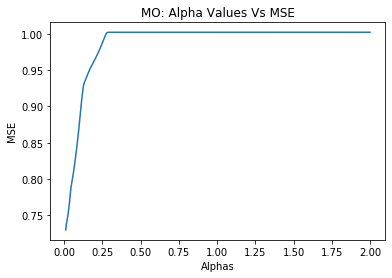

In [172]:
import matplotlib.pyplot as plt
alpha_set=model_cv.alphas_.T
np.mean(model_cv.mse_path_, axis=1)
plt.plot(alpha_set,np.mean(model_cv.mse_path_, axis=1))
plt.xlabel("Alphas")
plt.ylabel("MSE")
plt.title("MO: Alpha Values Vs MSE")


In [173]:
betas_market = best_lassom.coef_
max5_index_mark = [list(abs(betas_market)).index(x) for x in np.sort(abs(betas_market))[::-1][:20]]
min5_index_mark = [list(abs(betas_market)).index(x) for x in np.sort(abs(betas_market))[:5]]

betas_market[max5_index_mark]

market = pd.DataFrame([X_tr.columns[max5_index_mark], betas_market[max5_index_mark]]).T
market

,0,1
0,Country_tanzania,-0.704609
1,Country_kenya,-0.428121
2,YEAR_2017,-0.361493
3,LivestockHoldings,-0.143474
4,Country_mali,0.141832
5,Gender_MaleControl,-0.135908
6,Country_ethiopia,-0.133168
7,Country_burkinafaso,0.115908
8,crop_harvest_1_na,0.075881
9,crop_intercrop_1_na,0.0736125


In [174]:
feature_imp_mark  = pd.DataFrame([X_tr.columns, best_lassom.coef_]).T
feature_imp_mark = feature_imp_mark.sort_values(by = 1,ascending = False).reset_index(drop = True)
feature_imp_mark.iloc[0:15,:]

,0,1
0,Country_mali,0.141832
1,Country_burkinafaso,0.115908
2,crop_harvest_1_na,0.075881
3,crop_intercrop_1_na,0.0736125
4,Head_EducationLevel_secondary,0.039213
5,HouseholdType_couple,0.0353217
6,NrofMonthsWildFoodCons,0.0160913
7,farm_income_USD_PPP_pHH_Yr,0.00247081
8,score_HDDS_GoodSeason,0.00187342
9,total_income_USD_PPP_pHH_Yr,0.000899762


In [175]:
clean = pd.read_csv("../data/clean.csv")
clean  = clean.drop(["Country"], axis =1)
clean.YEAR = clean.YEAR.astype('category')
ppi_data = fun.delete_id_columns(clean) #1
ppi_data, pred_ppi = fun.drop_response_rows_with_NAs(ppi_data, "PPI_Likelihood", "Market_Orientation") #2
ppi_data = fun.replace_NAN_with_na(ppi_data) #3
ppi_data = fun.entry_to_lowercase(ppi_data) #4
ppi_data = fun.remove_underscores_spaces(ppi_data) #5
ppi_data = fun.convert_to_categorical(ppi_data) #6
ppi_data = fun.impute_data(ppi_data)
ppi_data = standarize_data(ppi_data)

In [176]:
X, y = get_dummyXs_y(ppi_data, "PPI_Likelihood")
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 2021)

lasso_cv_ppi=linear_model.LassoCV(alphas=np.arange(0.01,2,0.1))
model_cv=lasso_cv_ppi.fit(X_tr,y_tr)
model_cv.alpha_

0.01

In [177]:
model_cv.mse_path_

array([[0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.98931411, 1.02329464, 1.0606074 ],
       [0.99128436, 1.00795016, 0.

Text(0.5, 1.0, 'PPI:Alpha Values Vs MSE')

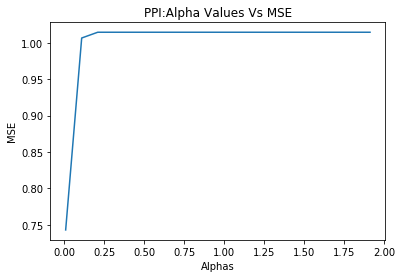

In [178]:
import matplotlib.pyplot as plt
alpha_set=model_cv.alphas_.T
np.mean(model_cv.mse_path_, axis=1)
plt.plot(alpha_set,np.mean(model_cv.mse_path_, axis=1))
plt.xlabel("Alphas")
plt.ylabel("MSE")
plt.title("PPI:Alpha Values Vs MSE")

In [179]:
best_lassop = linear_model.Lasso(alpha = model_cv.alpha_)
best_lassop.fit(X_tr,y_tr)
y_pred_lasso = best_lassop.predict(X_te)
MSE_lasso_ppi = metrics.mean_squared_error(y_te,y_pred_lasso)
MSE_lasso_ppi

0.7074800217709039

In [180]:
feature_imp_ppi  = pd.DataFrame([X_tr.columns, best_lassop.coef_]  ).T
feature_imp_ppi = feature_imp_ppi.sort_values(by = 1,ascending = False).reset_index(drop = True)
feature_imp_ppi.iloc[0:15,:]

,0,1
0,continent_africa,0.660745
1,YEAR_2015,0.460676
2,Head_EducationLevel_noschool,0.396116
3,YEAR_2017,0.357187
4,NrofMonthsWildFoodCons,0.124081
5,crop_name_1_millet,0.0871742
6,Head_EducationLevel_primary,0.0814309
7,HHsizemembers,0.0690304
8,HouseholdType_couple,0.0597672
9,HFIAS_status_severelyfi,0.0566652


In [181]:
combined_imp = pd.concat([feature_imp_ppi, feature_imp_mark], axis = 1).iloc[0:20,:]
combined_imp.columns = ["PPI Likelihood","Abs Coefficent","Market Orientation","Abs Coefficent"]
combined_imp

,PPI Likelihood,Abs Coefficent,Market Orientation,Abs Coefficent
0,continent_africa,0.660745,Country_mali,0.141832
1,YEAR_2015,0.460676,Country_burkinafaso,0.115908
2,Head_EducationLevel_noschool,0.396116,crop_harvest_1_na,0.075881
3,YEAR_2017,0.357187,crop_intercrop_1_na,0.0736125
4,NrofMonthsWildFoodCons,0.124081,Head_EducationLevel_secondary,0.039213
5,crop_name_1_millet,0.0871742,HouseholdType_couple,0.0353217
6,Head_EducationLevel_primary,0.0814309,NrofMonthsWildFoodCons,0.0160913
7,HHsizemembers,0.0690304,farm_income_USD_PPP_pHH_Yr,0.00247081
8,HouseholdType_couple,0.0597672,score_HDDS_GoodSeason,0.00187342
9,HFIAS_status_severelyfi,0.0566652,total_income_USD_PPP_pHH_Yr,0.000899762


In [182]:

betas_ppi = best_lassop.coef_


max5_index_ppi = [list(abs(betas_ppi)).index(x) for x in np.sort(abs(betas_ppi))[::-1][:20]]
min5_index_ppi = [list(abs(betas_ppi)).index(x) for x in np.sort(abs(betas_ppi))[:5]]

betas_ppi[max5_index_ppi]

ppi = pd.DataFrame([X_tr.columns[max5_index_ppi], betas_ppi[max5_index_ppi]]).T
combine = pd.concat([ppi, market], axis=1)

combine.columns = ["PPI Likelihood","Coefficent","Market Orientation","Coefficent"]
combine

,PPI Likelihood,Coefficent,Market Orientation,Coefficent
0,continent_africa,0.660745,Country_tanzania,-0.704609
1,YEAR_2015,0.460676,Country_kenya,-0.428121
2,Head_EducationLevel_noschool,0.396116,YEAR_2017,-0.361493
3,continent_centralamerica,-0.369956,LivestockHoldings,-0.143474
4,YEAR_2017,0.357187,Country_mali,0.141832
5,Head_EducationLevel_none,-0.253905,Gender_MaleControl,-0.135908
6,YEAR_2018,-0.24487,Country_ethiopia,-0.133168
7,Head_EducationLevel_secondary,-0.136431,Country_burkinafaso,0.115908
8,NrofMonthsWildFoodCons,0.124081,crop_harvest_1_na,0.075881
9,score_HDDS_BadSeason,-0.0915115,crop_intercrop_1_na,0.0736125
